# Learning a quadratic prior

This code attempts to learn a concave quadratic prior $J(x) = -\frac{1}{4}||x||_2^2$ in the context of a Hamilton-Jacobi PDE with a quadratic Hamiltonian $H(p) = \frac{1}{2}||p||_2^2$.
The LPN learns the function $\psi(x) = ||x||_2^2$.

## Import modules 

In [1]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/concave_quadratic_prior_16D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

## Parameters

In [2]:
# Parameters
# --- Parameters fof Experiment ---
dim_exp = 16  # Dimension (e.g., 2D, 4D, 8D as in the paper)
data_points_exp = 30000 # Example number of data points
iterations_exp_initial = 1 # Iterations for initial training phase
iterations_exp_long = 100000 # Iterations for longer training phase
a_exp = 4 # Grid limit for sampling y_j if using uniform, e.g., y_j in [-a, a]^d
spacing = 50 # For plotting cross-sections


# LPN model parameters
# Note: The defaults parameters are beta = 10, hidden = 50, layers = 4
beta = 10       # beta of softplus
hidden = 50     # number of hidden units
layers = 4      # number of layers
eps = 0.5
# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

# === Section ===

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch 

# === Section 4.1.2: L1 Prior Helper Functions ===

def inner_prod(x, y):
    return np.sum(x * y, axis=1)

def euclid_norm_sq(x):
    if x.ndim == 1:
        return np.sum(x*x)
    return np.sum(x * x, axis=1)


def cvx_true_concave_quad(y_points): # y_points is N x dim
    """
    Computes the target function psi(y) = ||y||_2^2 for the given problem.
    """
    return euclid_norm_sq(y_points)

def prior_true_concave_quad(x_points):
    """
    Computes the true concave prior J(x) = -1/4 * ||x||_2^2.
    """
    return -0.25 * euclid_norm_sq(x_points)

def invert_prior_lpn(x, model, INVERT_MODE):
    y = invert(x,model,INVERT_MODE)
    return y

def evaluate_learned_prior_lpn(x_eval_points, y_inverted_points, model):
    try:
        y_tensor = torch.from_numpy(y_inverted_points).float().to(device)
        psi_of_y_inverted = model.scalar(y_tensor).squeeze(1).detach().cpu().numpy()
    except NameError: 
        print("Warning: 'device' not defined. Assuming CPU for evaluate_learned_prior.")
        y_tensor = torch.from_numpy(y_inverted_points).float()
        psi_of_y_inverted = model.scalar(y_tensor).squeeze(1).detach().numpy()
    prior_est = inner_prod(x_eval_points, y_inverted_points) - 0.5 * euclid_norm_sq(x_eval_points) - psi_of_y_inverted
    return prior_est


def compute_square_cross_sections(a, spacing, dim):
    xi = np.linspace(-a, a, spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid)
    x1_0_points[:, 0] = xi
    x2_0_points = np.copy(grid)
    if dim > 1:
        x2_0_points[:, 1] = xi
    elif dim == 1:
        x2_0_points = x1_0_points.copy()
    return xi, x1_0_points, x2_0_points

def cross_sections_plots_concave_quad(model, a, spacing, INVERT_MODE, dim):
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    
    x1_0_psi_true = cvx_true_concave_quad(x1_0_points)
    x1_0_J_true = prior_true_concave_quad(x1_0_points)
    if dim > 1:
        x2_0_psi_true = cvx_true_concave_quad(x2_0_points)
        x2_0_J_true = prior_true_concave_quad(x2_0_points)
    else: 
        x2_0_psi_true = x1_0_psi_true 
        x2_0_J_true = x1_0_J_true
        
    x1_0_psi_est = cvx(x1_0_points, model) 
    y1_inverted = invert_prior_lpn(x1_0_points, model, INVERT_MODE)
    x1_0_J_est = evaluate_learned_prior_lpn(x1_0_points,y1_inverted, model)
    if dim > 1:
        x2_0_psi_est = cvx(x2_0_points, model)
        y2_inverted = invert_prior_lpn(x2_0_points, model, INVERT_MODE)
        x2_0_J_est = evaluate_learned_prior_lpn(x2_0_points,y2_inverted, model)
    else:
        x2_0_psi_est = x1_0_psi_est
        x2_0_J_est = x1_0_J_est
        
    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_psi_est, "-", ms=5, label="LPN (Learned $\\psi$)")
    plt.plot(xi, x1_0_psi_true, "--", ms=5, label="True $\\psi$ for $J(x)=\\|x\\|_1$")
    plt.grid(True)
    plt.title(f"$\\psi(y_1,0,...)$ - Dim {dim}, $J(x)=\\|x\\|_1$")
    plt.xlabel('$y_1$')
    plt.ylabel('$\\psi(y_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2) # Second plot for psi if dim > 1
        plt.plot(xi, x2_0_psi_est, "-", ms=5, label="LPN (Learned $\\psi$)")
        plt.plot(xi, x2_0_psi_true, "--", ms=5, label="True $\\psi$ for $J(x)=-1/4\\|x\\|_2^2$")
        plt.grid(True)
        plt.title(f"$\\psi(0,y_2,0,...)$ - Dim {dim}, $J(x)=-1/4\\|x\\|_2^2$")
        plt.xlabel('$y_2$')
        plt.ylabel('$\\psi(0,y_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_est, "-", label="LPN (Learned $J$)")
    plt.plot(xi, x1_0_J_true, "--", label="True $J(x)=-1/4\\|x\\|_2^2$")
    plt.grid(True)
    plt.title(f"Prior $J(x_1,0,...)$ - Dim {dim}, $J(x)=-1/4\\|x\\|_2^2$")
    plt.xlabel('$x_1$')
    plt.ylabel('$J(x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_est, "-", label="LPN (Learned $J$)")
        plt.plot(xi, x2_0_J_true, "--", label="True $J(x)=-1/4\\|x\\|_2^2$")
        plt.grid(True)
        plt.title(f"Prior $J(0,x_2,0,...)$ - Dim {dim}, $J(x)=-1/4\\|x\\|_2^2$")
        plt.xlabel('$x_2$')
        plt.ylabel('$J(0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    plt.show()

def plot_all_concave_quad(model, a, spacing, INVERT_MODE, dim):
    print(f"\n--- Plotting Cross Sections for Quadratic H, Quadratic concave Prior (Dim={dim}) ---")
    cross_sections_plots_concave_quad(model, a, spacing, INVERT_MODE, dim)



In [4]:
def evaluate_learned_H(model, a, spacing, dim):
    """
    Calculates and plots the approximate Hamiltonian H_theta.
    H_theta(p) = max_k { <p, eta_k> - b_k }
    where eta_k = x_k - grad_psi(x_k) and b_k = 0.5 * ||eta_k||^2
    """
    x_k_np = np.random.uniform(-a, a, (data_points_exp, dim))
    x_k_tensor = torch.from_numpy(x_k_np).float().to(device)
    x_k_tensor.requires_grad_(True)
    grad_psi_k_tensor = model(x_k_tensor)

    eta_k_tensor = x_k_tensor - grad_psi_k_tensor
    b_k_tensor = 0.5 * torch.sum(eta_k_tensor**2, dim=1, keepdim=True)

    xi = np.linspace(-a, a, spacing)
    p_eval_points_np = np.zeros((xi.size, dim))
    p_eval_points_np[:, 0] = xi
    p_eval_tensor = torch.from_numpy(p_eval_points_np).float().to(device)

    # Compute H_theta(p) for the cross-section
    inner_prods = torch.matmul(p_eval_tensor, eta_k_tensor.T)  # (spacing x data_points)
    H_theta_p_tensor = torch.max(inner_prods - b_k_tensor.T, dim=1, keepdim=True)[0]
    H_theta_p_np = H_theta_p_tensor.detach().cpu().numpy().flatten()

    # Compute true Hamiltonian H(p) = 0.5 * ||p||^2
    H_true_p_np = 0.5 * euclid_norm_sq(p_eval_points_np)

    plt.figure(figsize=(6,5))
    plt.plot(xi, H_theta_p_np, "-", label="Learned Hamiltonian $H_{\\theta}(p_1,0,...)$")
    plt.plot(xi, H_true_p_np, "--", label="True Hamiltonian $H(p)=1/2||p||_2^2$")
    plt.grid(True)
    plt.title(f"Hamiltonian Comparison - Dim {dim}")
    plt.xlabel('$p_1$')
    plt.ylabel('H(p)')
    plt.legend()
    plt.tight_layout()
    plt.show()


# --- Generate Training Data

In [5]:
# --- Generate Training Data for the new experiment ---
print("--- Generating Training Data for Concave Quadratic Prior ---")
y_j_exp_np = np.random.uniform(-a_exp, a_exp, (data_points_exp, dim_exp))
psi_samples_exp_np = cvx_true_concave_quad(y_j_exp_np)
psi_samples_exp_np = psi_samples_exp_np.reshape(-1, 1)

y_j_exp_tensor = torch.from_numpy(y_j_exp_np).float().to(device)
psi_samples_exp_tensor = torch.from_numpy(psi_samples_exp_np).float().to(device)
print(f"Generated training data: y_j_exp_tensor shape {y_j_exp_tensor.shape}, psi_samples_exp_tensor shape {psi_samples_exp_tensor.shape}")

# --- ADD THIS TO MOVE DATA TO GPU ---
y_j_exp_tensor = y_j_exp_tensor.to(device)
psi_samples_exp_tensor = psi_samples_exp_tensor.to(device)

--- Generating Training Data for Concave Quadratic Prior ---


Generated training data: y_j_exp_tensor shape torch.Size([20000, 16]), psi_samples_exp_tensor shape torch.Size([20000, 1])


## Training function

In [6]:
def single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    #elif loss_type == 0:
    #    loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 500:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [7]:

# --- Train and Plot with L2 Loss for the new experiment ---
print("\n--- Training LPN for Concave Quadratic Prior (Quadratic H) ---")
lpn_model_concave_quad_l2 = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta,eps=1e-3).to(device)
optimizer_concave_quad = torch.optim.Adam(lpn_model_concave_quad_l2.parameters(), lr=1e-4)

# Initial shorter training phase with a higher learning rate
for i in range(1):
     single_iteration(i, data_points_exp, lpn_model_concave_quad_l2, optimizer_concave_quad, y_j_exp_tensor, psi_samples_exp_tensor, loss_type=2, gamma_loss=None)

# Longer training phase with a reduced learning rate
for g in optimizer_concave_quad.param_groups:
    g["lr"] = 1e-4
for i in range(iterations_exp_long):
    if (i % 20000 == 0) and (i > 0): 
        # Multiply the current learning rate by 1e-1
        for g in optimizer_concave_quad.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")    
    single_iteration(i, data_points_exp, lpn_model_concave_quad_l2, optimizer_concave_quad, y_j_exp_tensor, psi_samples_exp_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_concave_quad_l2.state_dict(), os.path.join(MODEL_DIR, "ConcaveQuadraticH_l2.pth"))



--- Training LPN for Concave Quadratic Prior (Quadratic H) ---


iteration 0 loss 7645.07666015625
iteration 0 loss 5707.36865234375


iteration 500 loss 128.32730102539062


iteration 1000 loss 110.5885238647461


iteration 1500 loss 101.64237976074219


iteration 2000 loss 96.7677001953125


iteration 2500 loss 92.6414566040039


iteration 3000 loss 87.91572570800781


iteration 3500 loss 82.17393493652344


iteration 4000 loss 75.14993286132812


iteration 4500 loss 66.37210083007812


iteration 5000 loss 54.87310028076172


iteration 5500 loss 38.33730697631836


iteration 6000 loss 18.961408615112305


iteration 6500 loss 10.821098327636719


iteration 7000 loss 7.642169952392578


iteration 7500 loss 5.953630447387695


iteration 8000 loss 4.914896011352539


iteration 8500 loss 4.172908306121826


iteration 9000 loss 3.5697343349456787


iteration 9500 loss 3.0778424739837646


iteration 10000 loss 2.671436071395874


iteration 10500 loss 2.363746166229248


iteration 11000 loss 2.1233937740325928


iteration 11500 loss 1.9577150344848633


iteration 12000 loss 1.829421043395996


iteration 12500 loss 1.7189345359802246


iteration 13000 loss 1.6274561882019043


iteration 13500 loss 1.5522812604904175


iteration 14000 loss 1.4789198637008667


iteration 14500 loss 1.4318557977676392


iteration 15000 loss 1.3785886764526367


iteration 15500 loss 1.3336679935455322


iteration 16000 loss 1.2988250255584717


iteration 16500 loss 1.258159875869751


iteration 17000 loss 1.224331259727478


iteration 17500 loss 1.1917312145233154


iteration 18000 loss 1.260688066482544


iteration 18500 loss 1.1305710077285767


iteration 19000 loss 1.103493332862854


iteration 19500 loss 1.0730464458465576


iteration 20000 loss 1.0508558750152588


iteration 20500 loss 1.0250626802444458


iteration 21000 loss 1.0052354335784912


iteration 21500 loss 0.9852767586708069


iteration 22000 loss 0.961073637008667


iteration 22500 loss 0.9450104236602783


iteration 23000 loss 0.9268562197685242


iteration 23500 loss 0.9600900411605835


iteration 24000 loss 0.8919212818145752


iteration 24500 loss 0.8757978081703186


iteration 25000 loss 0.8616466522216797


iteration 25500 loss 0.8426029086112976


iteration 26000 loss 0.8263694047927856


iteration 26500 loss 0.8087980151176453


iteration 27000 loss 0.7957849502563477


iteration 27500 loss 0.7792273163795471


iteration 28000 loss 0.7627972364425659


iteration 28500 loss 0.7504118084907532


iteration 29000 loss 0.7373136281967163


iteration 29500 loss 0.7186152935028076


iteration 30000 loss 0.7051905989646912


iteration 30500 loss 0.6883307695388794


iteration 31000 loss 0.6748984456062317


iteration 31500 loss 0.658288836479187


iteration 32000 loss 0.6436313390731812


iteration 32500 loss 0.6284785270690918


iteration 33000 loss 0.6159652471542358


iteration 33500 loss 0.6520907282829285


iteration 34000 loss 0.5875710844993591


iteration 34500 loss 0.5744035840034485


iteration 35000 loss 0.5593999028205872


iteration 35500 loss 0.5457696914672852


iteration 36000 loss 0.5331230759620667


iteration 36500 loss 0.5199674963951111


iteration 37000 loss 0.5101811289787292


iteration 37500 loss 0.49709588289260864


iteration 38000 loss 0.5428388714790344


iteration 38500 loss 0.4744928479194641


iteration 39000 loss 0.46298739314079285


iteration 39500 loss 0.45177996158599854


iteration 40000 loss 0.4415408968925476


iteration 40500 loss 0.4319758713245392


iteration 41000 loss 0.421790212392807


iteration 41500 loss 0.4126495122909546


iteration 42000 loss 0.4030112326145172


iteration 42500 loss 0.39476293325424194


iteration 43000 loss 0.3859575688838959


iteration 43500 loss 0.377387672662735


iteration 44000 loss 0.36917635798454285


iteration 44500 loss 0.3668421804904938


iteration 45000 loss 0.35541293025016785


iteration 45500 loss 0.34670791029930115


iteration 46000 loss 0.3399583697319031


iteration 46500 loss 0.33299002051353455


iteration 47000 loss 0.3265582025051117


iteration 47500 loss 0.32307249307632446


iteration 48000 loss 0.3143622577190399


iteration 48500 loss 0.3085178732872009


iteration 49000 loss 0.30507180094718933


iteration 49500 loss 0.297698438167572


iteration 50000 loss 0.2922368049621582


iteration 50500 loss 0.28700360655784607


iteration 51000 loss 0.2819937467575073


iteration 51500 loss 0.2778862714767456


iteration 52000 loss 0.2730904519557953


iteration 52500 loss 0.27422279119491577


iteration 53000 loss 0.2643076479434967


iteration 53500 loss 0.2601288855075836


iteration 54000 loss 0.25807711482048035


iteration 54500 loss 0.2526353597640991


iteration 55000 loss 0.24965673685073853


iteration 55500 loss 0.24464818835258484


iteration 56000 loss 0.24095754325389862


iteration 56500 loss 0.26127707958221436


iteration 57000 loss 0.2340429127216339


iteration 57500 loss 0.23072020709514618


iteration 58000 loss 0.2307417392730713


iteration 58500 loss 0.2243829071521759


iteration 59000 loss 0.23660072684288025


iteration 59500 loss 0.21851633489131927


iteration 60000 loss 0.22604350745677948


iteration 60500 loss 0.21315595507621765


iteration 61000 loss 0.2107747495174408


iteration 61500 loss 0.20715463161468506


iteration 62000 loss 0.2044987678527832


iteration 62500 loss 0.20266523957252502


iteration 63000 loss 0.19978326559066772


iteration 63500 loss 0.1972815841436386


iteration 64000 loss 0.19981636106967926


iteration 64500 loss 0.19250065088272095


iteration 65000 loss 0.2232801765203476


iteration 65500 loss 0.18792787194252014


iteration 66000 loss 0.18697543442249298


iteration 66500 loss 0.18464307487010956


iteration 67000 loss 0.18438675999641418


iteration 67500 loss 0.17957082390785217


iteration 68000 loss 0.1804179847240448


iteration 68500 loss 0.1756410300731659


iteration 69000 loss 0.17386044561862946


iteration 69500 loss 0.17249388992786407


iteration 70000 loss 0.1704876571893692


iteration 70500 loss 0.17665910720825195


iteration 71000 loss 0.16666282713413239


iteration 71500 loss 0.17125271260738373


iteration 72000 loss 0.1632096916437149


iteration 72500 loss 0.1615970879793167


iteration 73000 loss 0.16139386594295502


iteration 73500 loss 0.15842176973819733


iteration 74000 loss 0.15685509145259857


iteration 74500 loss 0.15541206300258636


iteration 75000 loss 0.15388941764831543


iteration 75500 loss 0.1834123283624649


iteration 76000 loss 0.15101198852062225


iteration 76500 loss 0.1496766060590744


iteration 77000 loss 0.1518469899892807


iteration 77500 loss 0.1469188630580902


iteration 78000 loss 0.1508450210094452


iteration 78500 loss 0.14431534707546234


iteration 79000 loss 0.14305390417575836


iteration 79500 loss 0.1418377161026001


iteration 80000 loss 0.140616774559021


iteration 80500 loss 0.13950268924236298


iteration 81000 loss 0.138363316655159


iteration 81500 loss 0.1371515542268753


iteration 82000 loss 0.13603821396827698


iteration 82500 loss 0.13486601412296295


iteration 83000 loss 0.13392682373523712


iteration 83500 loss 0.13268423080444336


iteration 84000 loss 0.1316443532705307


iteration 84500 loss 0.1306062489748001


iteration 85000 loss 0.1300249546766281


iteration 85500 loss 0.13120615482330322


iteration 86000 loss 0.1300426721572876


iteration 86500 loss 0.12808586657047272


iteration 87000 loss 0.1257123053073883


iteration 87500 loss 0.12485889345407486


iteration 88000 loss 0.12390129268169403


iteration 88500 loss 0.12294577062129974


iteration 89000 loss 0.12220453470945358


iteration 89500 loss 0.1211920902132988


iteration 90000 loss 0.12254401296377182


iteration 90500 loss 0.12518595159053802


iteration 91000 loss 0.11863985657691956


iteration 91500 loss 0.11812310665845871


iteration 92000 loss 0.117180235683918


iteration 92500 loss 0.11902699619531631


iteration 93000 loss 0.11538247019052505


iteration 93500 loss 0.11460893601179123


iteration 94000 loss 0.11384500563144684


iteration 94500 loss 0.11717937886714935


iteration 95000 loss 0.12672796845436096


iteration 95500 loss 0.1140614002943039


iteration 96000 loss 0.11107446998357773


iteration 96500 loss 0.11102741211652756


iteration 97000 loss 0.14296197891235352


iteration 97500 loss 0.10909382253885269


iteration 98000 loss 0.10853908210992813


iteration 98500 loss 0.10734342038631439


iteration 99000 loss 0.1184677705168724


iteration 99500 loss 0.1137576624751091


L2 loss -- Plot


--- Plotting Cross Sections for Quadratic H, Quadratic concave Prior (Dim=16) ---
loss -0.43315589427948


loss -44.83955764770508


loss -65.17288970947266


loss -74.32701110839844


loss -77.8796157836914


loss -79.07450103759766


loss -79.40825653076172


loss -79.47947692871094


loss -79.48990631103516


loss -79.49083709716797


loss -79.4908676147461


loss -79.4908676147461


loss -79.4908676147461


loss -79.49087524414062


loss -79.4908676147461


loss -79.49085998535156


loss -79.4908676147461


loss -79.4908676147461


loss -79.4908676147461


loss -79.49087524414062


loss -79.4908676147461


loss -79.4908676147461


loss -79.4908676147461


loss -79.49087524414062


loss -79.49087524414062


loss -79.4908676147461


loss -79.4908676147461


loss -79.49085235595703


loss -79.49087524414062


loss -79.4908676147461


loss -79.4908676147461


loss -79.4908676147461


loss -79.49087524414062


loss -79.49087524414062


loss -79.49087524414062


loss -79.49087524414062


loss -79.4908676147461


loss -79.4908676147461


loss -79.4908676147461


loss -79.4908676147461


final mse:  5.140296632788477e-09
max, min: 2.0230203 -1.931916
loss -0.43315589427948


loss -45.408836364746094


loss -67.033447265625


loss -76.69332122802734


loss -80.21735382080078


loss -81.28191375732422


loss -81.53668212890625


loss -81.58126831054688


loss -81.58639526367188


loss -81.58673095703125


loss -81.58673095703125


loss -81.58673095703125


loss -81.58673858642578


loss -81.58674621582031


loss -81.58673858642578


loss -81.58674621582031


loss -81.58674621582031


loss -81.58673095703125


loss -81.58673095703125


loss -81.58673095703125


loss -81.58673858642578


loss -81.58673858642578


loss -81.58674621582031


loss -81.58673858642578


loss -81.58673095703125


loss -81.58673858642578


loss -81.58673858642578


loss -81.58674621582031


loss -81.58674621582031


loss -81.58673095703125


loss -81.58673095703125


loss -81.58673858642578


loss -81.58673858642578


loss -81.58674621582031


loss -81.58673858642578


loss -81.58673858642578


loss -81.58674621582031


loss -81.58673095703125


loss -81.58673095703125


loss -81.58673858642578


final mse:  4.357932237297746e-09
max, min: 1.7593399 -2.035637


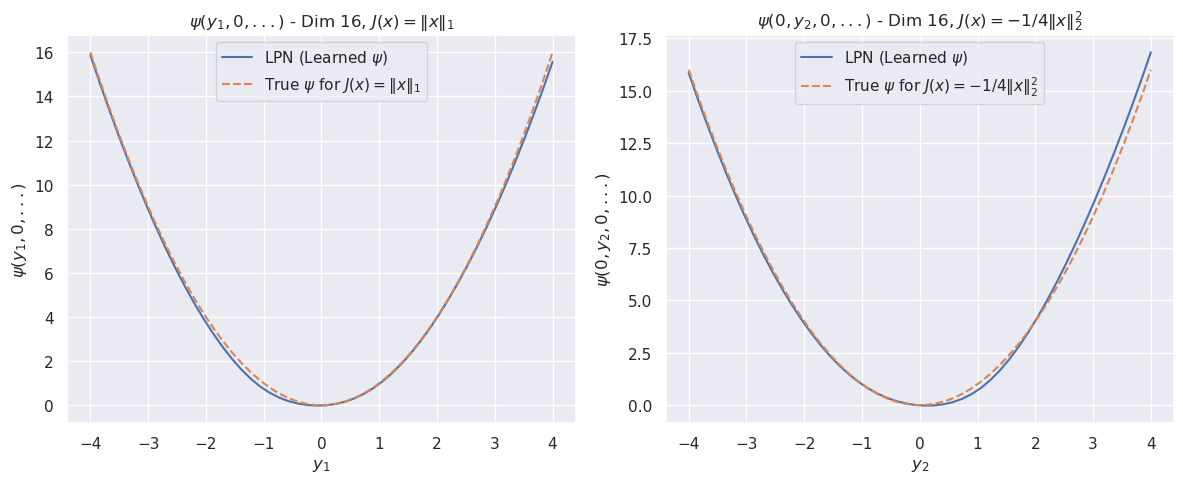

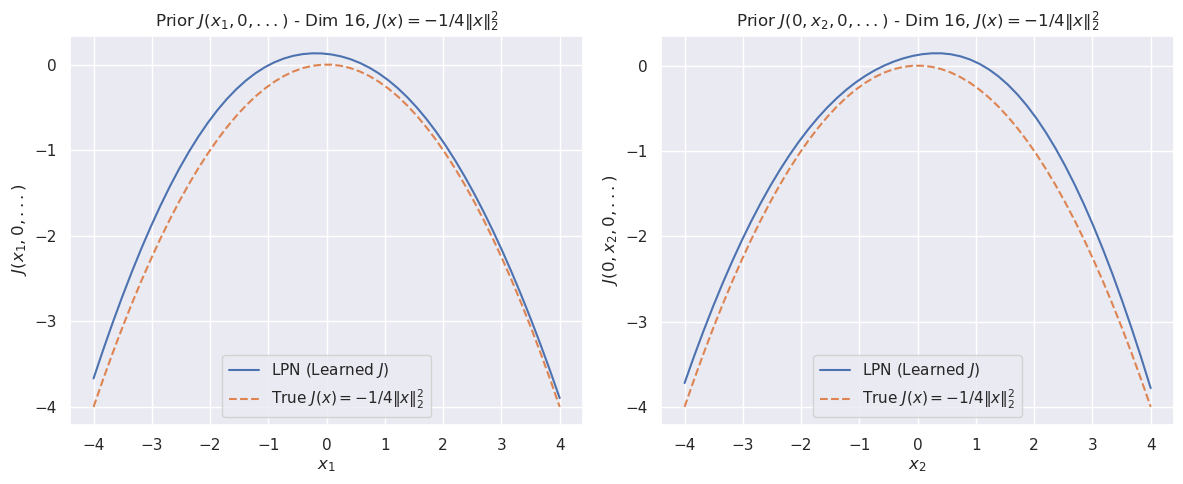

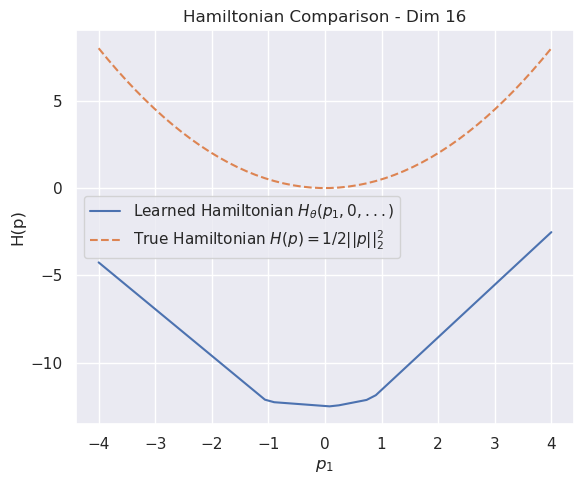

In [8]:
#print("\n--- Plotting Cross Sections for Quadratic H, Concave Quad Prior (Dim=4) ---")
plot_all_concave_quad(lpn_model_concave_quad_l2, a_exp, spacing, INVERT_MODE, dim_exp)

#print("\n--- Plotting Learned Hamiltonian for Quadratic H, Concave Quad Prior ---")
evaluate_learned_H(lpn_model_concave_quad_l2, a_exp, spacing, dim_exp)

Generated G samples: G_samples_tensor shape torch.Size([20000, 1])

--- Plotting Updated Prior j_hat(y) (Dim=16) ---


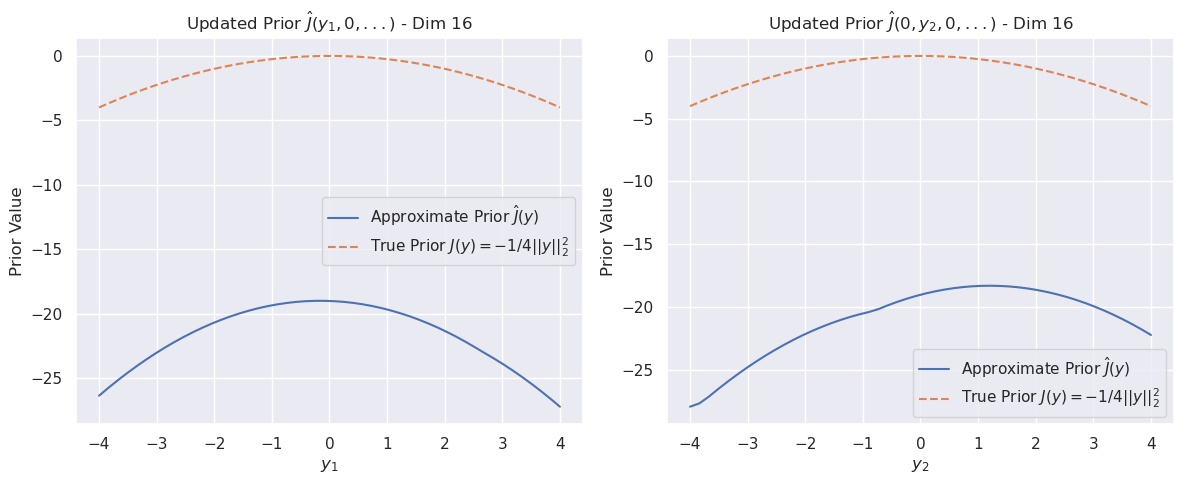

In [9]:
# --- Generate New Training Data for the Second LPN G(x) ---
# We use the same x_j_exp_tensor as the first LPN's training data for x_k
x_k_tensor = y_j_exp_tensor.clone().to(device)
x_k_tensor.requires_grad_(True)

# 1. Compute the gradient y_k = grad_x psi_theta(x_k, t=1)
# Get psi(x_k)
psi_x_k = lpn_model_concave_quad_l2.scalar(x_k_tensor)

# Get gradient y_k = grad_psi(x_k)
y_k_tensor = lpn_model_concave_quad_l2(x_k_tensor)

# 2. Evaluate the "new" samples G_k = <y_k, x_k> - psi_theta(x_k, 1) (from eq 26)
inner_prod_yk_xk = torch.sum(y_k_tensor * x_k_tensor, dim=1, keepdim=True)
G_samples_tensor_with_graph = inner_prod_yk_xk - psi_x_k

# Detach the tensor to treat G_k as fixed targets, breaking the connection
# to the first LPN's graph and preventing the RuntimeError during training.
G_samples_tensor = G_samples_tensor_with_graph.detach().to(device) 

# The input tensor x_k_tensor is still needed for the second LPN training,
# but it should also not require a gradient for that training.
x_k_tensor = x_k_tensor.detach()
x_k_tensor.requires_grad_(False) 
y_k_tensor = y_k_tensor.detach()
y_k_tensor.requires_grad_(False)
# G_samples_tensor now holds the target values G_k
print(f"Generated G samples: G_samples_tensor shape {G_samples_tensor.shape}")


# def evaluate_updated_prior_J_hat(y_points, model, x_k_np):
#     """
#     Implements the approximate prior.
#     """
    
#     # Pre-compute y_k = grad psi(x_k) from the training data
#     x_k_tensor = torch.from_numpy(x_k_np).float().to(device)
#     y_k_tensor = model(x_k_tensor)
#     y_k_np = y_k_tensor.detach().cpu().numpy()
    
#     # Compute S(x_k, 1) = psi(x_k, t=1) from the LPN
#     S_x_k = model.scalar(x_k_tensor)  # Shape (K, 1)
#     S_x_k_np = S_x_k.detach().cpu().numpy().flatten()  # Shape (K,)
    
#     # The constant term simplifies to just S(x_k, 1)
#     # Because: J_tilde(y_k) + 1/2||x_k - y_k||^2 
#     #        = [S(x_k,1) - 1/2||x_k - y_k||^2] + 1/2||x_k - y_k||^2 
#     #        = S(x_k, 1)
#     constants_k = S_x_k_np  # Shape (K,)
    
#     # Term 3: -1/2 * ||x_k - y||^2
#     # Broadcasting: x_k_np (K, 1, dim), y_points (1, N, dim) -> (K, N)
#     term3 = -0.5 * np.sum((x_k_np[:, np.newaxis, :] - y_points[np.newaxis, :, :])**2, axis=2)
    
#     # Term 4: 1/4 * ||y - y_k||^2
#     # Broadcasting: y_points (1, N, dim), y_k_np (K, 1, dim) -> (K, N)
#     term4 = 0.25 * np.sum((y_points[np.newaxis, :, :] - y_k_np[:, np.newaxis, :])**2, axis=2)

#     term5 = 0.5 * np.sum((x_k_np[:, np.newaxis, :])**2, axis=2)
#     all_terms = term5 - constants_k[:, np.newaxis] + term3 
    
#     # # Combine all terms: constants_k (K, 1) + term3 (K, N) + term4 (K, N)
#     # all_terms = constants_k[:, np.newaxis] + term3 + term4
    
#     # Take the max over K dimension
#     j_hat_est = np.max(all_terms, axis=0)
    
#     return j_hat_est

# def plot_updated_prior_J_hat(model, a, spacing, dim, x_k_np):
#     """
#     Generates cross-section plots for the prior j_hat(y) from the "Update".
#     """
#     print(f"\n--- Plotting Updated Prior j_hat(y) (Dim={dim}) ---")
#     xi, y1_0_points, y2_0_points = compute_square_cross_sections(a, spacing, dim)

#     # Compute true prior J(y)
#     y1_0_J_true = prior_true_concave_quad(y1_0_points)
    
#     # Compute estimated prior j_hat(y)
#     y1_0_J_hat_est = evaluate_updated_prior_J_hat(y1_0_points, model, x_k_np)

#     plt.figure(figsize=(12, 5))
    
#     plt.subplot(1, 2, 1)
#     plt.plot(xi, y1_0_J_hat_est, "-", label="Approximate Prior $\\hat{J}(y)$")
#     plt.plot(xi, y1_0_J_true, "--", label="True Prior $J(y)=-1/4||y||_2^2$")
#     plt.grid(True)
#     plt.title(f"Updated Prior $\\hat{{J}}(y_1,0,...)$ - Dim {dim}")
#     plt.xlabel('$y_1$')
#     plt.ylabel('Prior Value')
#     plt.legend()

#     if dim > 1:
#         y2_0_J_true = prior_true_concave_quad(y2_0_points)
#         y2_0_J_hat_est = evaluate_updated_prior_J_hat(y2_0_points, model, x_k_np)
        
#         plt.subplot(1, 2, 2)
#         plt.plot(xi, y2_0_J_hat_est, "-", label="Approximate Prior $\\hat{J}(y)$")
#         plt.plot(xi, y2_0_J_true, "--", label="True Prior $J(y)=-1/4||y||_2^2$")
#         plt.grid(True)
#         plt.title(f"Updated Prior $\\hat{{J}}(0,y_2,0,...)$ - Dim {dim}")
#         plt.xlabel('$y_2$')
#         plt.ylabel('Prior Value')
#         plt.legend()
        
#     plt.tight_layout()
#     plt.show()


# # We use the original training data 'x_j_exp_np' as our set of x_k points.
# #subset_size = 1000 
# x_k_subset_np = y_j_exp_np#[:subset_size, :]

# plot_updated_prior_J_hat(lpn_model_concave_quad_l2, a_exp, spacing, dim_exp, x_k_subset_np)


In [10]:
# --- Step 3: Train LPN G(x) ---
print("\n--- Training Second LPN G(x) for Concave Quadratic Prior ---")
# The target for this LPN is G_samples_tensor
# The input for this LPN is x_k_tensor
lpn_model_G = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta, eps=1e-3).to(device)
optimizer_G = torch.optim.Adam(lpn_model_G.parameters(), lr=1e-4)

# Initial shorter training phase
for i in range(1):
     single_iteration(i, data_points_exp, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_G.param_groups:
    g["lr"] = 1e-4 # Use a smaller learning rate for the long phase
for i in range(iterations_exp_long):
    if (i % 20000 == 0) and (i > 0): 
        # Multiply the current learning rate by 1e-1
        for g in optimizer_G.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")
    single_iteration(i, data_points_exp, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_G.state_dict(), os.path.join(MODEL_DIR, "G_network_l2.pth"))
print("Training of LPN for G(x) complete and model saved.")


--- Training Second LPN G(x) for Concave Quadratic Prior ---
iteration 0 loss 7894.66064453125
iteration 0 loss 4907.2978515625


iteration 500 loss 128.81121826171875


iteration 1000 loss 109.77561950683594


iteration 1500 loss 101.16864776611328


iteration 2000 loss 96.79100036621094


iteration 2500 loss 93.16796112060547


iteration 3000 loss 89.13005828857422


iteration 3500 loss 84.35514831542969


iteration 4000 loss 78.75003814697266


iteration 4500 loss 72.07740020751953


iteration 5000 loss 63.55472183227539


iteration 5500 loss 51.19792556762695


iteration 6000 loss 30.226192474365234


iteration 6500 loss 11.71134090423584


iteration 7000 loss 7.279398441314697


iteration 7500 loss 5.334988117218018


iteration 8000 loss 4.227494239807129


iteration 8500 loss 3.537315845489502


iteration 9000 loss 3.0277669429779053


iteration 9500 loss 2.6574416160583496


iteration 10000 loss 2.3977787494659424


iteration 10500 loss 2.2109785079956055


iteration 11000 loss 2.053675651550293


iteration 11500 loss 1.9512206315994263


iteration 12000 loss 1.8474311828613281


iteration 12500 loss 1.774616003036499


iteration 13000 loss 1.7119343280792236


iteration 13500 loss 1.6459318399429321


iteration 14000 loss 1.604163646697998


iteration 14500 loss 1.5663032531738281


iteration 15000 loss 1.525831937789917


iteration 15500 loss 1.4968931674957275


iteration 16000 loss 1.4713655710220337


iteration 16500 loss 1.4413729906082153


iteration 17000 loss 1.418242335319519


iteration 17500 loss 1.3982722759246826


iteration 18000 loss 1.3744488954544067


iteration 18500 loss 1.3521536588668823


iteration 19000 loss 1.3346612453460693


iteration 19500 loss 1.3137081861495972


iteration 20000 loss 1.2938777208328247


iteration 20500 loss 1.2807791233062744


iteration 21000 loss 1.264416217803955


iteration 21500 loss 1.2458246946334839


iteration 22000 loss 1.2307451963424683


iteration 22500 loss 1.2186137437820435


iteration 23000 loss 1.2041298151016235


iteration 23500 loss 1.1875134706497192


iteration 24000 loss 1.178399920463562


iteration 24500 loss 1.168152093887329


iteration 25000 loss 1.156095266342163


iteration 25500 loss 1.142365574836731


iteration 26000 loss 1.1350749731063843


iteration 26500 loss 1.1261447668075562


iteration 27000 loss 1.1155540943145752


iteration 27500 loss 1.106058120727539


iteration 28000 loss 1.0997223854064941


iteration 28500 loss 1.0918920040130615


iteration 29000 loss 1.0823179483413696


iteration 29500 loss 1.0732474327087402


iteration 30000 loss 1.0683292150497437


iteration 30500 loss 1.0622206926345825


iteration 31000 loss 1.054829716682434


iteration 31500 loss 1.046759009361267


iteration 32000 loss 1.040716528892517


iteration 32500 loss 1.03606379032135


iteration 33000 loss 1.030256986618042


iteration 33500 loss 1.0231561660766602


iteration 34000 loss 1.017106533050537


iteration 34500 loss 1.0127296447753906


iteration 35000 loss 1.0072529315948486


iteration 35500 loss 1.0005332231521606


iteration 36000 loss 0.9952002763748169


iteration 36500 loss 0.9908552765846252


iteration 37000 loss 0.9853838682174683


iteration 37500 loss 0.9785623550415039


iteration 38000 loss 0.9740393161773682


iteration 38500 loss 0.9691656827926636


iteration 39000 loss 0.9629645943641663


iteration 39500 loss 0.9572451114654541


iteration 40000 loss 0.9536038637161255


iteration 40500 loss 0.9490247964859009


iteration 41000 loss 0.9436710476875305


iteration 41500 loss 0.9382110238075256


iteration 42000 loss 0.9351271986961365


iteration 42500 loss 0.9312368631362915


iteration 43000 loss 0.9269039630889893


iteration 43500 loss 0.9410424828529358


iteration 44000 loss 0.9176613092422485


iteration 44500 loss 0.9141108393669128


iteration 45000 loss 0.9090765118598938


iteration 45500 loss 0.9032657742500305


iteration 46000 loss 0.9004978537559509


iteration 46500 loss 0.8976278305053711


iteration 47000 loss 0.8940626978874207


iteration 47500 loss 0.889714241027832


iteration 48000 loss 0.8848358988761902


iteration 48500 loss 0.882267951965332


iteration 49000 loss 0.8794749975204468


iteration 49500 loss 0.8751150369644165


iteration 50000 loss 0.870315432548523


iteration 50500 loss 0.8671712875366211


iteration 51000 loss 0.8641663789749146


iteration 51500 loss 0.8602685332298279


iteration 52000 loss 0.8598177433013916


iteration 52500 loss 0.8534917831420898


iteration 53000 loss 0.8506833910942078


iteration 53500 loss 0.8469677567481995


iteration 54000 loss 0.8435236215591431


iteration 54500 loss 0.8405448794364929


iteration 55000 loss 0.8378201127052307


iteration 55500 loss 0.8343827724456787


iteration 56000 loss 0.8497782945632935


iteration 56500 loss 0.8283452987670898


iteration 57000 loss 0.8267671465873718


iteration 57500 loss 0.822981059551239


iteration 58000 loss 0.8199301362037659


iteration 58500 loss 0.8163689970970154


iteration 59000 loss 0.8137924671173096


iteration 59500 loss 0.8105608224868774


iteration 60000 loss 0.8065891265869141


iteration 60500 loss 0.8046860098838806


iteration 61000 loss 0.802635908126831


iteration 61500 loss 0.8000476360321045


iteration 62000 loss 0.7968304753303528


iteration 62500 loss 0.7933998703956604


iteration 63000 loss 0.7915876507759094


iteration 63500 loss 0.7893029451370239


iteration 64000 loss 0.7864239811897278


iteration 64500 loss 0.7869614362716675


iteration 65000 loss 0.780246913433075


iteration 65500 loss 0.7782908082008362


iteration 66000 loss 0.775787889957428


iteration 66500 loss 0.7732231020927429


iteration 67000 loss 1.0005884170532227


iteration 67500 loss 0.7672591805458069


iteration 68000 loss 0.7655957937240601


iteration 68500 loss 0.7636098861694336


iteration 69000 loss 0.7610856294631958


iteration 69500 loss 0.7569816708564758


iteration 70000 loss 0.7541735172271729


iteration 70500 loss 0.7656474709510803


iteration 71000 loss 0.7489008903503418


iteration 71500 loss 0.746626615524292


iteration 72000 loss 0.7436955571174622


iteration 72500 loss 0.7407260537147522


iteration 73000 loss 0.7385445833206177


iteration 73500 loss 0.7394683361053467


iteration 74000 loss 0.7323862910270691


iteration 74500 loss 0.7305520176887512


iteration 75000 loss 0.7284353375434875


iteration 75500 loss 0.725598931312561


iteration 76000 loss 0.7226415276527405


iteration 76500 loss 0.7200610041618347


iteration 77000 loss 0.7167955040931702


iteration 77500 loss 0.7144694328308105


iteration 78000 loss 0.7118809819221497


iteration 78500 loss 0.709735631942749


iteration 79000 loss 0.7064322233200073


iteration 79500 loss 0.7042639255523682


iteration 80000 loss 0.7017626762390137


iteration 80500 loss 0.703625500202179


iteration 81000 loss 0.6964156031608582


iteration 81500 loss 0.6940746903419495


iteration 82000 loss 0.6917763948440552


iteration 82500 loss 0.6878208518028259


iteration 83000 loss 0.6861575245857239


iteration 83500 loss 0.6840466856956482


iteration 84000 loss 0.6813692450523376


iteration 84500 loss 0.6780650019645691


iteration 85000 loss 0.675825297832489


iteration 85500 loss 0.6733762621879578


iteration 86000 loss 0.6702349781990051


iteration 86500 loss 0.6675859093666077


iteration 87000 loss 0.6652888655662537


iteration 87500 loss 0.6617157459259033


iteration 88000 loss 0.6593579649925232


iteration 88500 loss 0.6569625735282898


iteration 89000 loss 0.6540189385414124


iteration 89500 loss 0.650825560092926


iteration 90000 loss 0.6488487720489502


iteration 90500 loss 0.6463993787765503


iteration 91000 loss 0.6431947946548462


iteration 91500 loss 0.6404263377189636


iteration 92000 loss 0.6378807425498962


iteration 92500 loss 0.6345452666282654


iteration 93000 loss 0.6319972276687622


iteration 93500 loss 0.6292003989219666


iteration 94000 loss 0.6257516145706177


iteration 94500 loss 0.6235340237617493


iteration 95000 loss 0.6209703683853149


iteration 95500 loss 0.6175644397735596


iteration 96000 loss 0.6150332093238831


iteration 96500 loss 0.6144278049468994


iteration 97000 loss 0.609014630317688


iteration 97500 loss 0.6112499237060547


iteration 98000 loss 0.6116276979446411


iteration 98500 loss 0.6002746224403381


iteration 99000 loss 0.597135603427887


iteration 99500 loss 0.5942076444625854


Training of LPN for G(x) complete and model saved.



--- Plotting Estimated Prior J(x) from LPN 2 ---


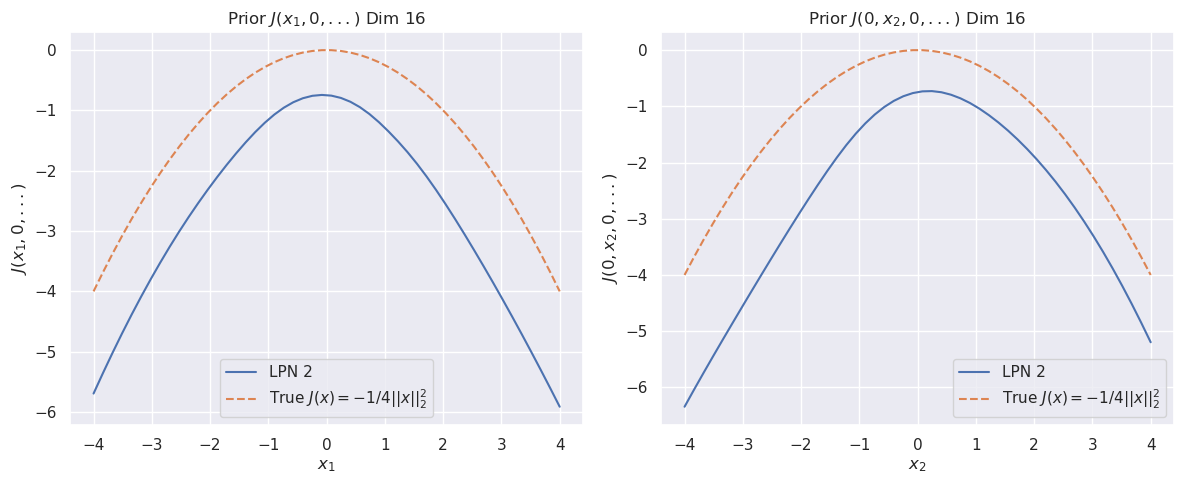

In [11]:
def evaluate_learned_J_G_network(x_points, model_G):
    """
    Evaluates the learned prior J(x) using the trained G(x) network.
    J(x) = G(x) - 0.5 * ||x||^2
    """
    # Convert to tensor
    x_tensor = torch.from_numpy(x_points).float().to(device)
    
    # Get G(x) from the second LPN model
    G_x = model_G.scalar(x_tensor)
    
    # Compute 0.5 * ||x||^2
    x_norm_sq_np = euclid_norm_sq(x_points)
    x_norm_sq_tensor = torch.from_numpy(x_norm_sq_np).float().to(device).reshape(-1, 1)

    # Apply the formula: J_est = G(x) - 0.5 * ||x||^2
    J_est = G_x - 0.5 * x_norm_sq_tensor
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np

def plot_J_G_network(model_G, a, spacing, dim):
    """Plots the cross-sections of the estimated prior J(x) from the G network."""
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    
    # True Prior
    x1_0_J_true = prior_true_concave_quad(x1_0_points)
    if dim > 1:
        x2_0_J_true = prior_true_concave_quad(x2_0_points)
    else:
        x2_0_J_true = x1_0_J_true
        
    # Estimated Prior from G(x) Network
    x1_0_J_G_est = evaluate_learned_J_G_network(x1_0_points, model_G)
    if dim > 1:
        x2_0_J_G_est = evaluate_learned_J_G_network(x2_0_points, model_G)
    else:
        x2_0_J_G_est = x1_0_J_G_est
    
    print("\n--- Plotting Estimated Prior J(x) from LPN 2 ---")
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_G_est, "-", label="LPN 2")
    plt.plot(xi, x1_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
    plt.grid(True)
    plt.title(f"Prior $J(x_1,0,...)$ Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('$J(x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_G_est, "-", label="LPN 2")
        plt.plot(xi, x2_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
        plt.grid(True)
        plt.title(f"Prior $J(0,x_2,0,...)$ Dim {dim}")
        plt.xlabel('$x_2$')
        plt.ylabel('$J(0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    #plt.savefig('G_network_prior_plot.png')
    
# --- Execute Plotting ---
plot_J_G_network(lpn_model_G, a_exp, spacing, dim_exp)